## Title: Leveraging Quadratic Polynomials in Python for Advanced Data Analysis

### Revision 1 - With function to fit a polynomial model with Regularization and Cross-Validation with implementation K-fold cross-validation

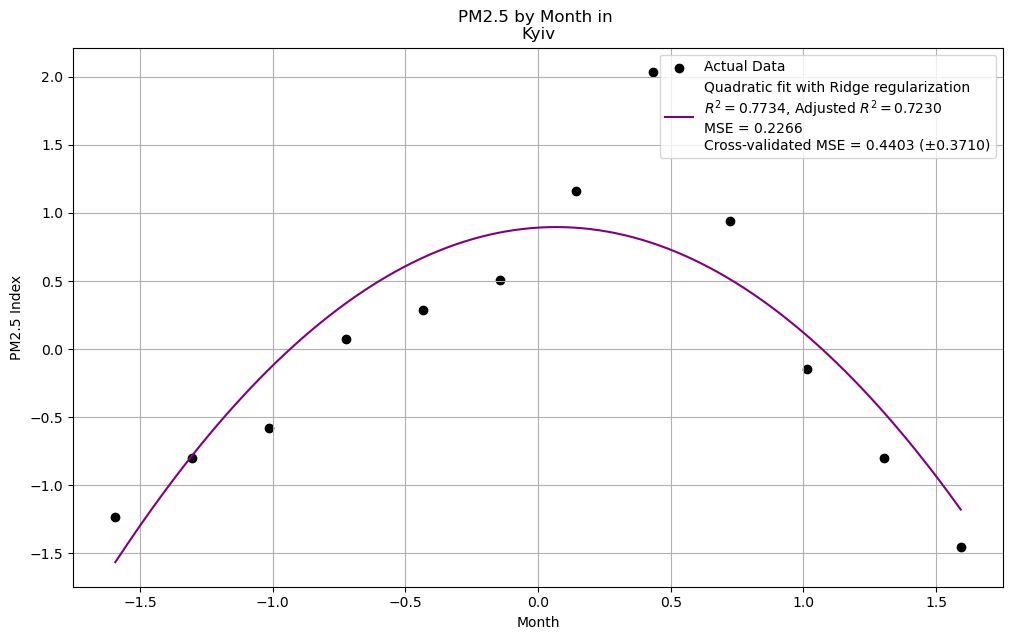

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

def handle_missing_data(data, method):
    if method == 'remove':
        data.dropna(inplace=True)
    elif method == 'mean':
        data.fillna(data.mean(), inplace=True)
    elif method == 'median':
        data.fillna(data.median(), inplace=True)
    elif method == 'ffill':
        data.fillna(method='ffill', inplace=True)
    elif method == 'bfill':
        data.fillna(method='bfill', inplace=True)
    else:
        raise ValueError("Method should be 'remove', 'mean', 'median', 'ffill', or 'bfill'")
    return data

def calculate_metrics(y_true, y_pred, degree):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r_squared = 1 - (ss_res / ss_tot)
    adjusted_r_squared = 1 - (1 - r_squared) * (len(y_true) - 1) / (len(y_true) - degree - 1)
    mse = mean_squared_error(y_true, y_pred)
    return r_squared, adjusted_r_squared, mse

# User inputs for the descriptive elements of the plot
description = input("Enter the location description (e.g., Kyiv, Shcherbakovskaya St.): ")
pollution_name = input("Enter the pollution name (e.g., PM2.5): ")
y_label = input("Enter the y-axis label (e.g., PM2.5 Index): ")
missing_data_method = input("Choose how to handle missing data ('remove', 'mean', 'median', 'ffill', 'bfill'): ")

# Read data from a CSV file
data = pd.read_csv('https://raw.githubusercontent.com/rsipakov/QuadraticPolynomialsPyDA/main/notebooks/pm_data.csv')

# Handle missing data based on user choice
data = handle_missing_data(data, missing_data_method)

# Outlier Detection and Treatment using Z-Score method
z_scores = np.abs((data - data.mean()) / data.std())
data = data[(z_scores < 3).all(axis=1)]

# Extracting months and values
months = data['Month'].to_numpy()
values = data['Values'].to_numpy()

# Data Normalization using StandardScaler
scaler = StandardScaler()
months_scaled = scaler.fit_transform(months.reshape(-1, 1)).flatten()
values_scaled = scaler.fit_transform(values.reshape(-1, 1)).flatten()

# Set up the polynomial features and Ridge regression model
poly_features = PolynomialFeatures(degree=2)
ridge_reg = Ridge(alpha=1.0)
model = make_pipeline(poly_features, ridge_reg)

# Implement K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cross_val_scores = cross_val_score(model, months_scaled.reshape(-1, 1), values_scaled, cv=kf, scoring='neg_mean_squared_error')

# Train the model on the full dataset
model.fit(months_scaled.reshape(-1, 1), values_scaled)
quadratic_pred = model.predict(months_scaled.reshape(-1, 1))
quadratic_metrics = calculate_metrics(values_scaled, quadratic_pred, 2)

# Generate a smooth curve by evaluating the polynomial at many points
x = np.linspace(months_scaled.min(), months_scaled.max(), 200)
quadratic_y = model.predict(x.reshape(-1, 1))

# Create the plot
plt.figure(figsize=(12, 7))

# Plot the data and the fitted curve
plt.scatter(months_scaled, values_scaled, color='black', label='Actual Data')
plt.plot(x, quadratic_y, color='purple', label=f'Quadratic fit with Ridge regularization\n'
                                               f'$R^2 = {quadratic_metrics[0]:.4f}$, Adjusted $R^2 = {quadratic_metrics[1]:.4f}$\n'
                                               f'MSE = {quadratic_metrics[2]:.4f}\n'
                                               f'Cross-validated MSE = {-cross_val_scores.mean():.4f} (±{cross_val_scores.std():.4f})')

# Title and labels using user inputs
plt.title(f'{pollution_name} by Month in \n{description}')
plt.xlabel('Month')
plt.ylabel(y_label)

# Add legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
